In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [2]:
file_path = "member.uid___A001_X2d20_X39ab.Cloverleaf_sci.spw27.cube.I.pbcor.fits-Z-profile-Region_3-Statistic_Mean-Coordinate_Current-smoothed-2025-07-07-16-47-35.tsv"
df = pd.read_csv(file_path, sep="\t", skiprows=5)

In [ ]:
#清理欄位名稱
df.columns = [col.strip().lstrip('#').strip() for col in df.columns]

讀到的欄位名稱： Index(['smooth: Gaussian', 'Unnamed: 1'], dtype='object')


In [4]:
#確保兩欄都是數值
df[df.columns[0]] = pd.to_numeric(df[df.columns[0]], errors="coerce")
df[df.columns[1]] = pd.to_numeric(df[df.columns[1]], errors="coerce")
df = df.dropna()

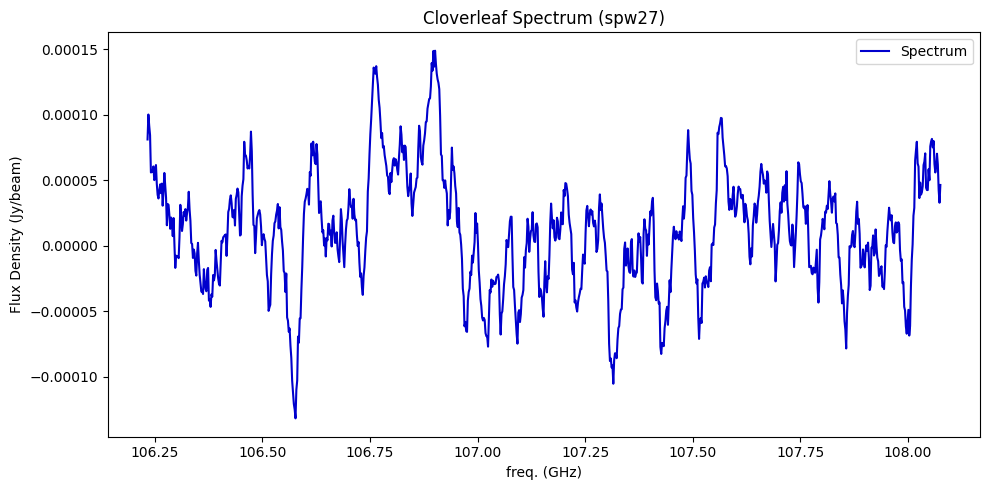

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(df[df.columns[0]], df[df.columns[1]], label="Spectrum", color="mediumblue")
plt.xlabel("freq. (GHz)")
plt.ylabel("Flux Density (Jy/beam)")
plt.title("Cloverleaf Spectrum (spw27)")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
y_smoothed = gaussian_filter1d(df[df.columns[1]], sigma=12)

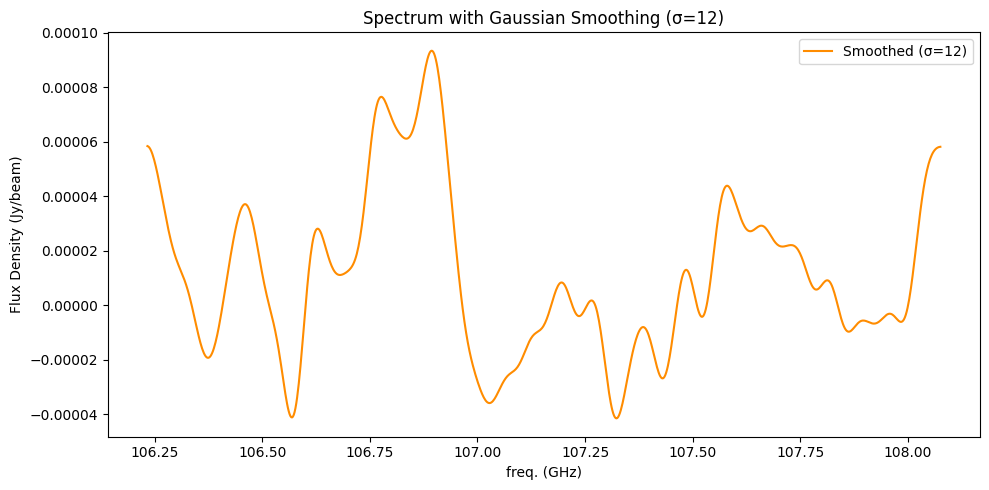

In [13]:
plt.figure(figsize=(10, 5))
#plt.plot(df[df.columns[0]], df[df.columns[1]], label="Original Spectrum", color="mediumblue", alpha=0.5)
plt.plot(df[df.columns[0]], y_smoothed, label="Smoothed (σ=12)", color="darkorange")
plt.xlabel("freq. (GHz)")
plt.ylabel("Flux Density (Jy/beam)")
plt.title("Spectrum with Gaussian Smoothing (σ=12)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#加入譜線(沒存到HAHA)
#line_file = "member.uid___A001_X2d20_X39ab.Cloverleaf_sci.spw27.cube.I.pbcor.fits-Z-profile-Region_3-Statistic_Mean-Coordinate_Current-2025-07-07-16-47-35.tsv.tsv"
#df_lines = pd.read_csv(file_path, sep="\t", skiprows=5)
#df_lines.columns = [col.strip().lstrip('#').strip() for col in df_lines.columns]
#line_positions = pd.to_numeric(df_lines[df_lines.columns[0]], errors="coerce").dropna()

#換成手打
my_lines = [(106.857,"H2O")]

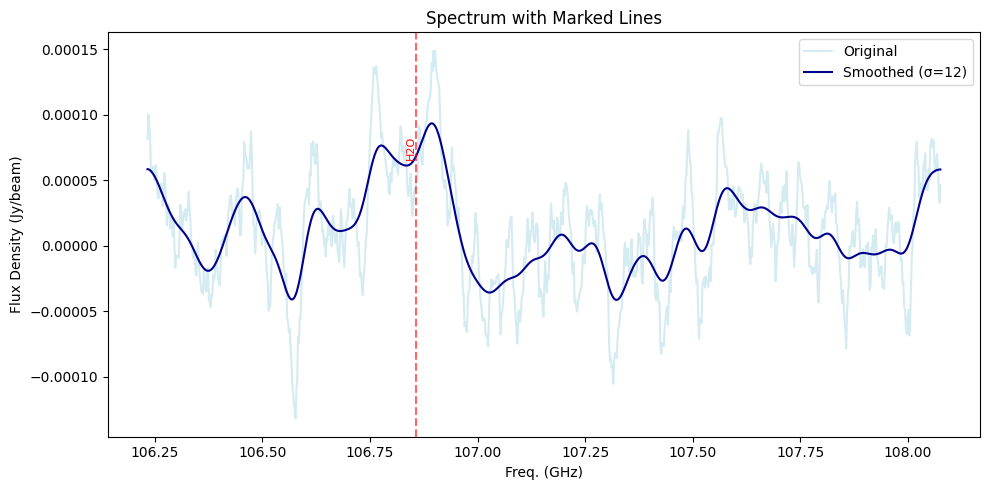

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(df[df.columns[0]], df[df.columns[1]], label="Original", color="lightblue", alpha=0.5)
plt.plot(df[df.columns[0]], y_smoothed, label="Smoothed (σ=12)", color="darkblue")
for freq, label in my_lines:
    plt.axvline(freq, color="red", linestyle="--", alpha=0.6)
    plt.text(freq, max(y_smoothed)*0.9, label, rotation=90, color="red", fontsize=8, ha='right', va='top')
plt.xlabel("Freq. (GHz)")
plt.ylabel("Flux Density (Jy/beam)")
plt.title("Spectrum with Marked Lines")
plt.legend()
plt.tight_layout()
plt.show()
